# Import packages

In [53]:
from dotenv import load_dotenv
import os
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [34]:
# Load HF key
load_dotenv()
api_key = os.getenv("HF_API_KEY")

In [31]:
url = "https://api-inference.huggingface.co/models/mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis"
headers = { "Authorization": f"Bearer {api_key}" }
payload = { "inputs": "How Britain can seize the next decade" } # "inputs" will accept single string or list of strings

response = requests.post(url, headers=headers, json=payload)
response.json()

[[{'label': 'positive', 'score': 0.6430162191390991},
  {'label': 'neutral', 'score': 0.355707585811615},
  {'label': 'negative', 'score': 0.001276212278753519}]]

In [28]:
ft_articles_df = pd.read_csv("ft_all_crypto.csv")

In [35]:
import pandas as pd
import requests
import time  # for rate-limiting

# Set up Hugging Face API

url = "https://api-inference.huggingface.co/models/mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis"
headers = {"Authorization": f"Bearer {api_key}"}

# Define the sentiment analysis function
def get_sentiment(snippet):
    if not snippet or not isinstance(snippet, str):
        return "unknown"
    
    payload = {"inputs": snippet}
    try:
        response = requests.post(url, headers=headers, json=payload)
        response.raise_for_status()  # raise exception for bad status
        result = response.json()
        if isinstance(result, list) and len(result) > 0:
            return result[0][0]['label']
    except Exception as e:
        print(f"Error processing: {snippet[:50]}... | Error: {e}")
        return "error"

# Apply to DataFrame
ft_articles_df['sentiment'] = ft_articles_df['snippet'].apply(lambda x: get_sentiment(x))

# Optional: if API rate limit is an issue, insert a delay
# ft_articles_df['sentiment'] = ft_articles_df['snippet'].apply(lambda x: (time.sleep(1), get_sentiment(x))[1])


Error processing: Penalty for Mike Novogratz’s group comes as SEC sc... | Error: 503 Server Error: Service Temporarily Unavailable for url: https://api-inference.huggingface.co/models/mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis
Error processing: But the craziness from the White House has not tur... | Error: 503 Server Error: Service Temporarily Unavailable for url: https://api-inference.huggingface.co/models/mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis
Error processing: FCA seeks to encourage more investment in shares a... | Error: 503 Server Error: Service Temporarily Unavailable for url: https://api-inference.huggingface.co/models/mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis
Error processing: The greenback’s dominance was forged on trade, all... | Error: 503 Server Error: Service Temporarily Unavailable for url: https://api-inference.huggingface.co/models/mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis


In [149]:
# filter df for articles where date is not null
ft_articles_df.drop(columns=['Unnamed: 0'], inplace=True)

In [151]:
ft_articles_df.to_csv("ft_all_crypto_sentiment.csv", index=False)

In [40]:
ft_articles_df.groupby('sentiment').size()

sentiment
error         4
negative    136
neutral     549
positive    251
unknown      15
dtype: int64

# Daily Sentiment

In [ ]:
# converting sentiment to numerical values
sentiment_map = {"positive": 1, "neutral": 0, "negative": -1}
ft_articles_df['sentiment_score'] = ft_articles_df['sentiment'].map(sentiment_map)

# Average sentiment per day per crypto
daily_sentiment = ft_articles_df.groupby(['date', 'symbol'])['sentiment_score'].mean().reset_index()


In [42]:
daily_sentiment

,date,symbol,sentiment_score
0,2023-01-16,ETH,-1.0
1,2023-01-18,ETH,0.5
2,2023-01-20,ETH,-0.5
3,2023-01-25,ETH,1.0
4,2023-01-31,ETH,0.0
...,...,...,...
637,2025-04-02,BTC,0.5
638,2025-04-02,ETH,0.0
639,2025-04-02,USDT,0.5
640,2025-04-03,BTC,1.0


In [ ]:
# merge with daily prices
## load dataset
daily_prices = pd.read_csv("alphavantage_all_crypto.csv")


In [46]:
merged_df = pd.merge(daily_prices, daily_sentiment, on=['date', 'symbol'], how='inner')

In [49]:
merged_df.head()

,date,symbol,open,high,low,close,volume,sentiment_score
0,2025-04-03,BTC,75661.51,76895.06,73069.00,75302.11,710.685420,1.0
1,2025-04-02,BTC,78900.68,81300.00,75600.00,75617.59,685.408274,0.5
2,2025-03-28,BTC,80780.15,81029.40,77212.08,77969.88,466.629894,NaN
3,2025-03-27,BTC,80969.75,80989.34,80654.59,80751.73,9.353113,0.0
4,2025-03-26,BTC,81050.89,81878.00,79838.51,80976.04,330.751332,0.0


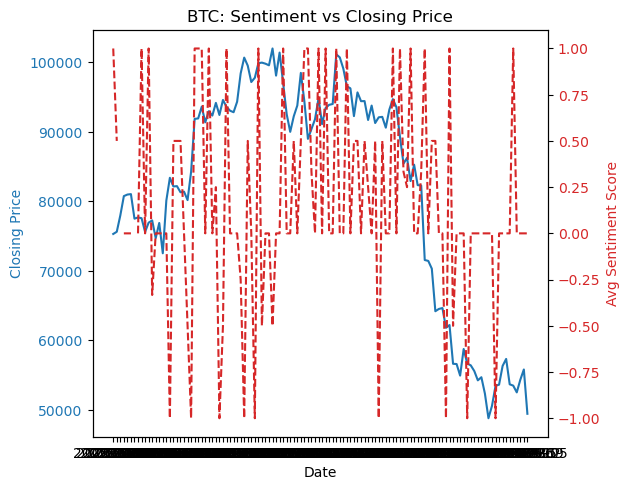

In [ ]:
# visualize the relationship

# Example for Bitcoin
btc_df = merged_df[merged_df['symbol'] == 'BTC']

fig, ax1 = plt.subplots()

ax1.set_xlabel('Date')
ax1.set_ylabel('Closing Price', color='tab:blue')
ax1.plot(btc_df['date'], btc_df['close'], color='tab:blue', label='Close Price')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.set_ylabel('Avg Sentiment Score', color='tab:red')
ax2.plot(btc_df['date'], btc_df['sentiment_score'], color='tab:red', linestyle='--', label='Sentiment')
ax2.tick_params(axis='y', labelcolor='tab:red')

fig.tight_layout()
plt.title('BTC: Sentiment vs Closing Price')
plt.show()


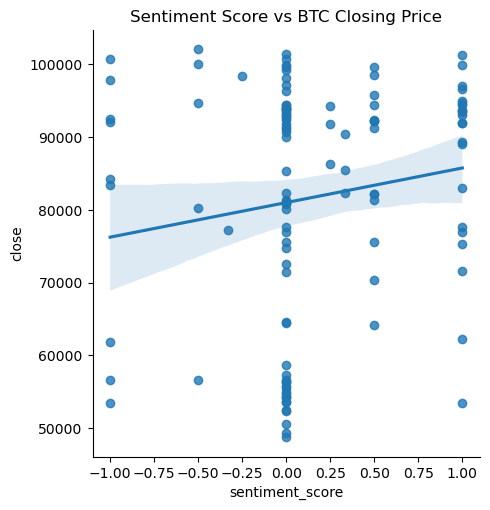

In [ ]:


sns.lmplot(x='sentiment_score', y='close', data=btc_df)
plt.title('Sentiment Score vs BTC Closing Price')
plt.show()


In [52]:
correlation = btc_df[['sentiment_score', 'close']].corr().iloc[0, 1]
print(f"Correlation between BTC sentiment and closing price: {correlation:.2f}")


Correlation between BTC sentiment and closing price: 0.16


In [56]:
# Using daily returns instead of closing price
daily_prices = daily_prices.sort_values(by=['symbol', 'date'])
daily_prices['daily_return'] = daily_prices.groupby('symbol')['close'].pct_change()

In [58]:
# merge with daily sentiment

merged_df = pd.merge(daily_prices, daily_sentiment, on=['date', 'symbol'], how='inner')


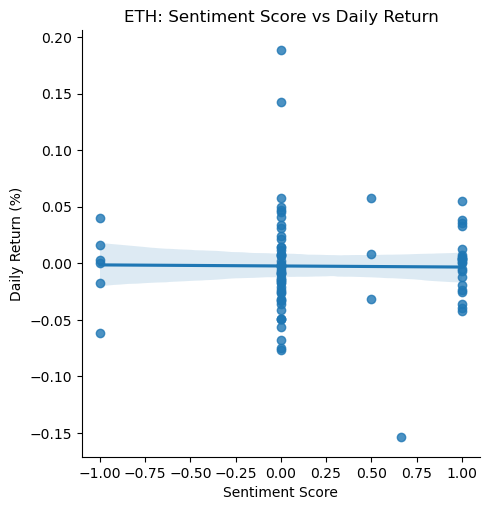

In [63]:
import seaborn as sns
import matplotlib.pyplot as plt

# Example for Ethereum
eth_df = merged_df[merged_df['symbol'] == 'ETH']

sns.lmplot(x='sentiment_score', y='daily_return', data=eth_df)
plt.title('ETH: Sentiment Score vs Daily Return')
plt.xlabel('Sentiment Score')
plt.ylabel('Daily Return (%)')
plt.show()


In [64]:
correlation = eth_df[['sentiment_score', 'daily_return']].corr().iloc[0, 1]
print(f"Correlation between ETH sentiment and daily return: {correlation:.2f}")


Correlation between ETH sentiment and daily return: -0.01


In [105]:
# Lag sentiment by 1 day

# Copy the merged DataFrame
lagged_df = merged_df.copy()

# Shift sentiment by 1 day *within each symbol*
lagged_df['lagged_sentiment'] = lagged_df.groupby('symbol')['sentiment_score'].shift(1)


In [106]:
# Drop rows with missing values (from shift or pct_change)
lagged_df = lagged_df.dropna(subset=['lagged_sentiment', 'daily_return'])

# Correlation for ETH
eth_lagged = lagged_df[lagged_df['symbol'] == 'ETH']
correlation = eth_lagged[['lagged_sentiment', 'daily_return']].corr().iloc[0, 1]
print(f"Lagged correlation between BTC sentiment and next-day return: {correlation:.2f}")


Lagged correlation between BTC sentiment and next-day return: 0.13


In [81]:
# compare lagged correlations across all cryptos
for symbol in lagged_df['symbol'].unique():
    df = lagged_df[lagged_df['symbol'] == symbol]
    corr = df[['lagged_sentiment', 'daily_return']].corr().iloc[0, 1]
    print(f"{symbol}: Lagged sentiment vs next-day return correlation = {corr:.2f}")


BTC: Lagged sentiment vs next-day return correlation = 0.11
ETH: Lagged sentiment vs next-day return correlation = 0.13
USDT: Lagged sentiment vs next-day return correlation = 0.09
XRP: Lagged sentiment vs next-day return correlation = 0.09


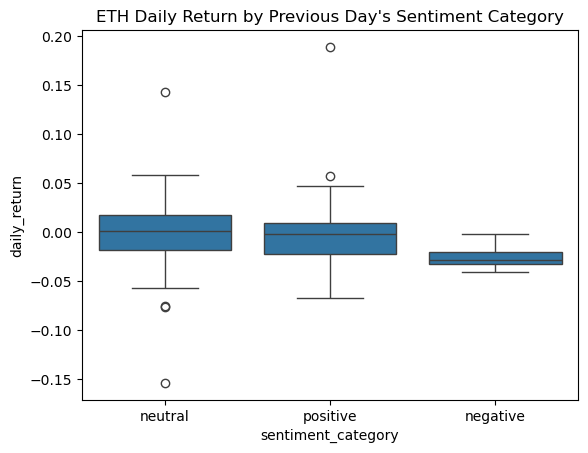

In [84]:
def classify_sentiment(score):
    if score > 0.5: return 'positive'
    elif score < -0.5: return 'negative'
    else: return 'neutral'

lagged_df['sentiment_category'] = lagged_df['lagged_sentiment'].apply(classify_sentiment)

# Boxplot of returns by sentiment category
sns.boxplot(x='sentiment_category', y='daily_return', data=lagged_df[lagged_df['symbol'] == 'ETH'])
plt.title("ETH Daily Return by Previous Day's Sentiment Category")
plt.show()


In [ ]:
# Regression analysis
import statsmodels.api as sm

X = eth_lagged['lagged_sentiment']
y = eth_lagged['daily_return']
X = sm.add_constant(X)

model = sm.OLS(y, X).fit()
print(model.summary())


<Axes: xlabel='date', ylabel='lagged_sentiment'>

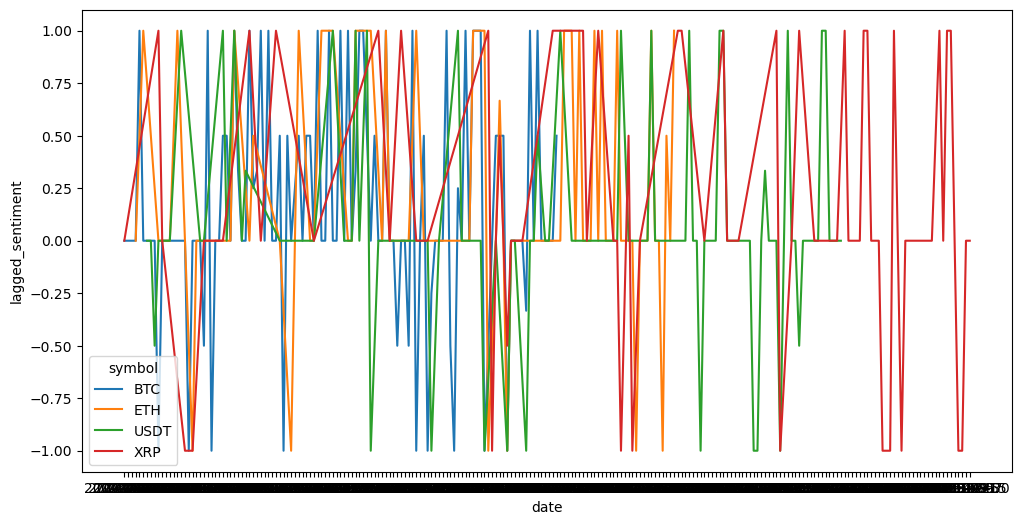

In [86]:
# lineplot to visualize sentiment by date
plt.figure(figsize=(12, 6))
sns.lineplot(data=lagged_df, x='date', y='lagged_sentiment', hue='symbol')

# Visualizing Weekly sentiment fluctuations

In [143]:
# group SENTIMENT by week
ft_articles_df['date'] = pd.to_datetime(ft_articles_df['date'])

weekly_sentiment = (
    ft_articles_df
    .set_index('date')
    .groupby('symbol')['sentiment_score']
    .resample('W')  # weekly resample
    .mean()
    .reset_index()
)



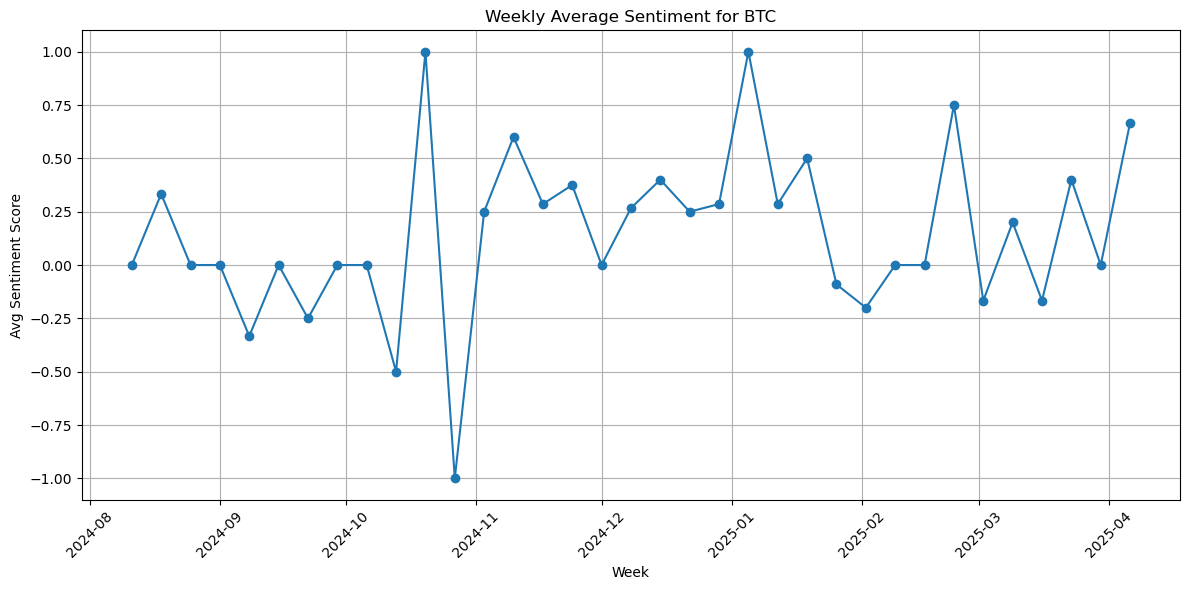

In [144]:
# Plot for one symbol (e.g., BTC)
symbol = 'BTC'
btc_weekly = weekly_sentiment[weekly_sentiment['symbol'] == symbol]

plt.figure(figsize=(12, 6))
plt.plot(btc_weekly['date'], btc_weekly['sentiment_score'], marker='o')
plt.title(f"Weekly Average Sentiment for {symbol}")
plt.xlabel("Week")
plt.ylabel("Avg Sentiment Score")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [146]:
# Visualizing monthly sentiment fluctuations
monthly_sentiment = (
    ft_articles_df
    .set_index('date')
    .groupby('symbol')['sentiment_score']
    .resample('ME')  # monthly resample
    .mean()
    .reset_index()
)

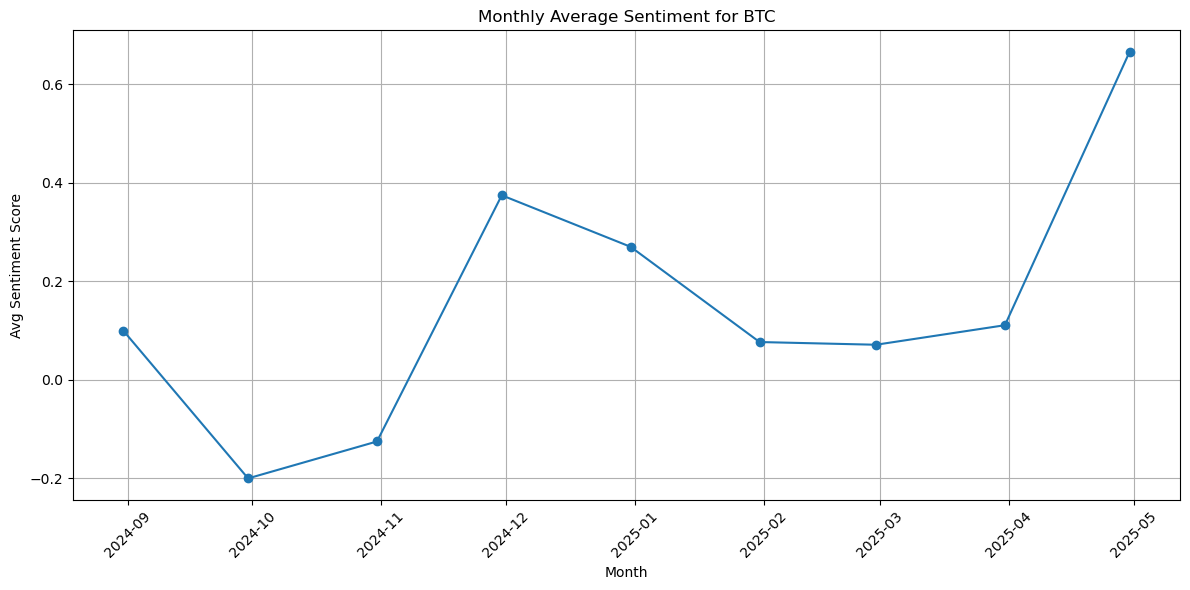

In [147]:
# Plot for one symbol (e.g., BTC)
symbol = 'BTC'
btc_montly = monthly_sentiment[monthly_sentiment['symbol'] == symbol]

plt.figure(figsize=(12, 6))
plt.plot(btc_montly['date'], btc_montly['sentiment_score'], marker='o')
plt.title(f"Monthly Average Sentiment for {symbol}")
plt.xlabel("Month")
plt.ylabel("Avg Sentiment Score")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

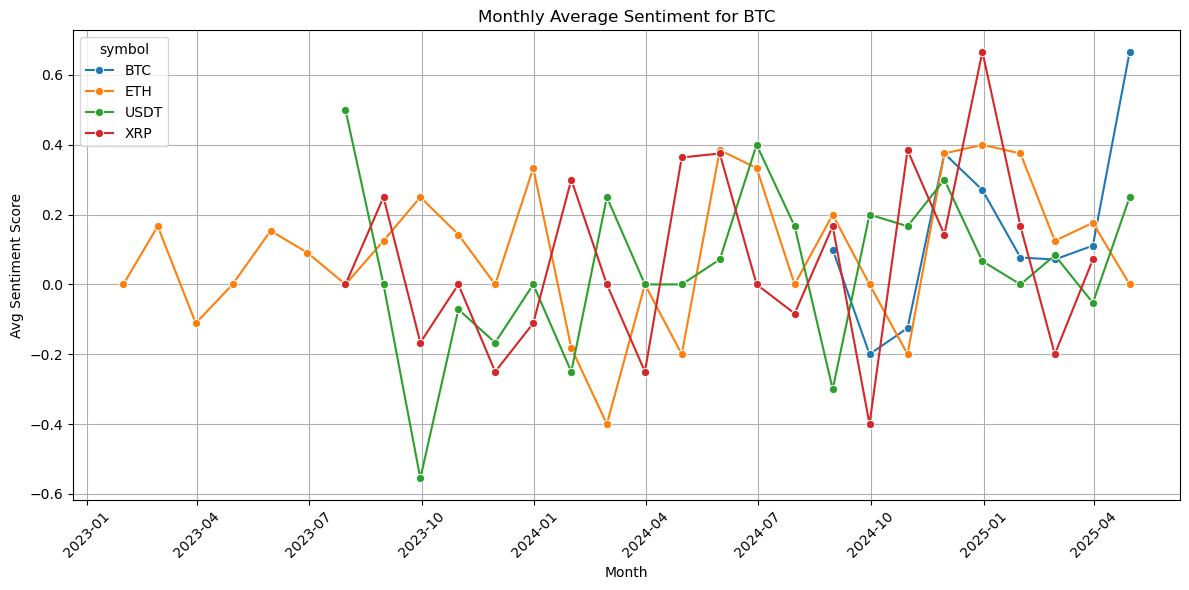

In [148]:
plt.figure(figsize=(12, 6))
sns.lineplot(data = monthly_sentiment, x ='date', y = 'sentiment_score', marker='o', hue='symbol')
plt.title(f"Monthly Average Sentiment for {symbol}")
plt.xlabel("Month")
plt.ylabel("Avg Sentiment Score")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()